# PRE - PROCESSING

## Import functions

In [1]:
#pip install meteostat

In [2]:
import holidays # For working with holiday data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Import the necessary module
from sklearn.ensemble import RandomForestRegressor

from datetime import datetime
from meteostat import Stations, Daily # For working with weather data
from xgboost import plot_importance


from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

import joblib

/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
## Features Functions

def create_datetime_features(df):
    """
    Creates time series features from datetime index
    Adapted from: https://www.kaggle.com/code/robikscube/tutorial-time-series-forecasting-with-xgboost#Look-at-Worst-and-Best-Predicted-Days
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    df['date'] = pd.to_datetime(df.index.date)
    return df

def get_holiday_features(df, country_code='US'):
    """
    Creates holiday features from datetime index
    """
    year_range = list(range(min(df.index.year), max(df.index.year) + 1))
    country_holidays = holidays.country_holidays(
        country_code,
        years=year_range,
        observed=False
    )
    holiday_df = pd.DataFrame(country_holidays.items())
    holiday_df.columns = ['date', 'holiday']
    holiday_df['date'] = pd.to_datetime(holiday_df['date'])
    return holiday_df

def get_weather_features(df, lat, lon):
    """
    Creates weather features based on latitude and longitude
    """
    room_temperature = 20  # Weather data is in Celsius
    start = min(df.index)
    end = max(df.index)

    stations = Stations()
    stations = stations.nearby(lat, lon)
    station = stations.fetch(1)

    # Get daily data
    weather_data = Daily(station['wmo'][0], start, end)
    weather_data = weather_data.fetch()
    weather_data = weather_data.dropna(axis=1)
    weather_data = weather_data.reset_index()
    weather_data['tmin_abs_diff_from_room_temperature'] = abs(weather_data['tmin'] - room_temperature)
    weather_data['tmax_abs_diff_from_room_temperature'] = abs(weather_data['tmax'] - room_temperature)
    weather_data = weather_data.rename(columns ={'time': 'date'})

    return weather_data

## Import data and feature engineering

In [4]:
main = 'https://raw.githubusercontent.com/Brunchcode/Forecasting-Energy-Consumption-Using-Machine-Learning/main/data/Timeseries/Timeseries_PJM_DOM_consumption_2006_to_2024.csv'

data_main = pd.read_csv(main,index_col=[0], parse_dates=[0])
data = create_datetime_features(data_main)
holiday_features = get_holiday_features(data)
weather_features = get_weather_features(data, 37.5407, -77.4360) # Richmond Capital of Virgina
data['datetime'] = data.index
data = data.merge(holiday_features, how='left', on='date')
data['holiday'] = data['holiday'].fillna('')
data = pd.get_dummies(data)
data = data.merge(weather_features, how='left', on='date')


remove_for_case_study = datetime(2020, 1, 1)
data_till_2019 = data.loc[data['datetime'] <= remove_for_case_study].copy()
case_study_data = data.loc[data['datetime'] > remove_for_case_study].copy()

In [5]:
data.head()

,energy_consumption_mw,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,...,holiday_Thanksgiving,holiday_Veterans Day,holiday_Washington's Birthday,tavg,tmin,tmax,prcp,wspd,tmin_abs_diff_from_room_temperature,tmax_abs_diff_from_room_temperature
0,9250.0,2006-01-01,0,6,1,1,2006,1,1,52,...,False,False,False,5.8,-1.1,11.7,0.0,4.0,21.1,8.3
1,8978.0,2006-01-01,1,6,1,1,2006,1,1,52,...,False,False,False,5.8,-1.1,11.7,0.0,4.0,21.1,8.3
2,8773.0,2006-01-01,2,6,1,1,2006,1,1,52,...,False,False,False,5.8,-1.1,11.7,0.0,4.0,21.1,8.3
3,8671.0,2006-01-01,3,6,1,1,2006,1,1,52,...,False,False,False,5.8,-1.1,11.7,0.0,4.0,21.1,8.3
4,8664.0,2006-01-01,4,6,1,1,2006,1,1,52,...,False,False,False,5.8,-1.1,11.7,0.0,4.0,21.1,8.3


In [6]:
data.tail()

,energy_consumption_mw,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,...,holiday_Thanksgiving,holiday_Veterans Day,holiday_Washington's Birthday,tavg,tmin,tmax,prcp,wspd,tmin_abs_diff_from_room_temperature,tmax_abs_diff_from_room_temperature
162882,20498.376,2024-07-31,19,2,3,7,2024,213,31,31,...,False,False,False,26.2,22.2,32.2,0.3,7.9,2.2,12.2
162883,19814.648,2024-07-31,20,2,3,7,2024,213,31,31,...,False,False,False,26.2,22.2,32.2,0.3,7.9,2.2,12.2
162884,18910.259,2024-07-31,21,2,3,7,2024,213,31,31,...,False,False,False,26.2,22.2,32.2,0.3,7.9,2.2,12.2
162885,17645.255,2024-07-31,22,2,3,7,2024,213,31,31,...,False,False,False,26.2,22.2,32.2,0.3,7.9,2.2,12.2
162886,16421.592,2024-07-31,23,2,3,7,2024,213,31,31,...,False,False,False,26.2,22.2,32.2,0.3,7.9,2.2,12.2


In [7]:
data_till_2019.head()

,energy_consumption_mw,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,...,holiday_Thanksgiving,holiday_Veterans Day,holiday_Washington's Birthday,tavg,tmin,tmax,prcp,wspd,tmin_abs_diff_from_room_temperature,tmax_abs_diff_from_room_temperature
0,9250.0,2006-01-01,0,6,1,1,2006,1,1,52,...,False,False,False,5.8,-1.1,11.7,0.0,4.0,21.1,8.3
1,8978.0,2006-01-01,1,6,1,1,2006,1,1,52,...,False,False,False,5.8,-1.1,11.7,0.0,4.0,21.1,8.3
2,8773.0,2006-01-01,2,6,1,1,2006,1,1,52,...,False,False,False,5.8,-1.1,11.7,0.0,4.0,21.1,8.3
3,8671.0,2006-01-01,3,6,1,1,2006,1,1,52,...,False,False,False,5.8,-1.1,11.7,0.0,4.0,21.1,8.3
4,8664.0,2006-01-01,4,6,1,1,2006,1,1,52,...,False,False,False,5.8,-1.1,11.7,0.0,4.0,21.1,8.3


In [8]:
data_till_2019.tail()

,energy_consumption_mw,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,...,holiday_Thanksgiving,holiday_Veterans Day,holiday_Washington's Birthday,tavg,tmin,tmax,prcp,wspd,tmin_abs_diff_from_room_temperature,tmax_abs_diff_from_room_temperature
122708,11442.870,2019-12-31,20,1,4,12,2019,365,31,1,...,False,False,False,10.9,5.0,13.9,0.0,11.9,15.0,6.1
122709,11166.770,2019-12-31,21,1,4,12,2019,365,31,1,...,False,False,False,10.9,5.0,13.9,0.0,11.9,15.0,6.1
122710,10838.550,2019-12-31,22,1,4,12,2019,365,31,1,...,False,False,False,10.9,5.0,13.9,0.0,11.9,15.0,6.1
122711,10592.674,2019-12-31,23,1,4,12,2019,365,31,1,...,False,False,False,10.9,5.0,13.9,0.0,11.9,15.0,6.1
122712,10364.707,2020-01-01,0,2,1,1,2020,1,1,1,...,False,False,False,7.1,1.7,12.2,0.0,13.7,18.3,7.8


In [9]:
case_study_data.head()

,energy_consumption_mw,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,...,holiday_Thanksgiving,holiday_Veterans Day,holiday_Washington's Birthday,tavg,tmin,tmax,prcp,wspd,tmin_abs_diff_from_room_temperature,tmax_abs_diff_from_room_temperature
122713,10291.858,2020-01-01,1,2,1,1,2020,1,1,1,...,False,False,False,7.1,1.7,12.2,0.0,13.7,18.3,7.8
122714,10252.082,2020-01-01,2,2,1,1,2020,1,1,1,...,False,False,False,7.1,1.7,12.2,0.0,13.7,18.3,7.8
122715,10303.804,2020-01-01,3,2,1,1,2020,1,1,1,...,False,False,False,7.1,1.7,12.2,0.0,13.7,18.3,7.8
122716,10588.920,2020-01-01,4,2,1,1,2020,1,1,1,...,False,False,False,7.1,1.7,12.2,0.0,13.7,18.3,7.8
122717,10980.540,2020-01-01,5,2,1,1,2020,1,1,1,...,False,False,False,7.1,1.7,12.2,0.0,13.7,18.3,7.8


In [10]:
case_study_data.tail()

,energy_consumption_mw,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,...,holiday_Thanksgiving,holiday_Veterans Day,holiday_Washington's Birthday,tavg,tmin,tmax,prcp,wspd,tmin_abs_diff_from_room_temperature,tmax_abs_diff_from_room_temperature
162882,20498.376,2024-07-31,19,2,3,7,2024,213,31,31,...,False,False,False,26.2,22.2,32.2,0.3,7.9,2.2,12.2
162883,19814.648,2024-07-31,20,2,3,7,2024,213,31,31,...,False,False,False,26.2,22.2,32.2,0.3,7.9,2.2,12.2
162884,18910.259,2024-07-31,21,2,3,7,2024,213,31,31,...,False,False,False,26.2,22.2,32.2,0.3,7.9,2.2,12.2
162885,17645.255,2024-07-31,22,2,3,7,2024,213,31,31,...,False,False,False,26.2,22.2,32.2,0.3,7.9,2.2,12.2
162886,16421.592,2024-07-31,23,2,3,7,2024,213,31,31,...,False,False,False,26.2,22.2,32.2,0.3,7.9,2.2,12.2


# Test MODEL BUILDING

## Prediction with date time features (entire data)

In [11]:
split_date = datetime(2016, 1, 1)
train = data.loc[data['datetime'] <= split_date].copy()
test = data.loc[data['datetime'] > split_date].copy()
train_cols = ['hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear', 'dayofmonth']
X_train = train[train_cols]
y_train = train['energy_consumption_mw']
X_test = test[train_cols]
y_test = test['energy_consumption_mw']

rfr_dt_reg = RandomForestRegressor()
rfr_dt_reg.fit(X_train, y_train)
predictions = rfr_dt_reg.predict(X_test)

# Evaluation
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"R^2: {rfr_dt_reg.score(X_test, y_test)}")

RMSE: 2353.6664810465277
MAE: 1822.8554979305939
MAPE: 0.14630001189805691
R^2: 0.15622751456318562


## Prediction with weather features and datetime (entire data)

In [12]:
split_date = datetime(2016, 1, 1)
train = data.loc[data['datetime'] <= split_date].copy()
test = data.loc[data['datetime'] > split_date].copy()
train_drop_cols = ['date', 'datetime', 'energy_consumption_mw']
X_train = train.drop(columns=train_drop_cols)
y_train = train['energy_consumption_mw']
X_test = test.drop(columns=train_drop_cols)
y_test = test['energy_consumption_mw']

rfr_all_reg = RandomForestRegressor()
rfr_all_reg.fit(X_train, y_train)
predictions = rfr_all_reg.predict(X_test)

# Evaluation
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"R^2: {rfr_all_reg.score(X_test, y_test)}")

RMSE: 1636.657331921038
MAE: 1269.0827748738184
MAPE: 0.1013960568084971
R^2: 0.5920085752321165


## Prediction with date time features (2006 - 2019)

In [13]:
split_date = datetime(2016, 1, 1)
train = data_till_2019.loc[data_till_2019['datetime'] <= split_date].copy()
test = data_till_2019.loc[data_till_2019['datetime'] > split_date].copy()
train_cols = ['hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear', 'dayofmonth']
X_train = train[train_cols]
y_train = train['energy_consumption_mw']
X_test = test[train_cols]
y_test = test['energy_consumption_mw']

rfr_dt2019_reg = RandomForestRegressor()
rfr_dt2019_reg.fit(X_train, y_train)
predictions = rfr_dt2019_reg.predict(X_test)

# Evaluation
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"R^2: {rfr_dt2019_reg.score(X_test, y_test)}")

RMSE: 2029.2835894304067
MAE: 1471.927391176905
MAPE: 0.12666129896200468
R^2: 0.31146098356837526


## Prediction with weather features and datetime (2006 - 2019)

In [14]:
split_date = datetime(2016, 1, 1)
train = data_till_2019.loc[data_till_2019['datetime'] <= split_date].copy()
test = data_till_2019.loc[data_till_2019['datetime'] > split_date].copy()
train_drop_cols = ['date', 'datetime', 'energy_consumption_mw']
X_train = train.drop(columns=train_drop_cols)
y_train = train['energy_consumption_mw']
X_test = test.drop(columns=train_drop_cols)
y_test = test['energy_consumption_mw']

rfr_all2019_reg = RandomForestRegressor()
rfr_all2019_reg.fit(X_train, y_train)
predictions = rfr_all2019_reg.predict(X_test)

# Evaluation
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"R^2: {rfr_all2019_reg.score(X_test, y_test)}")

RMSE: 735.573532434685
MAE: 568.9102806872847
MAPE: 0.049156676115223126
R^2: 0.9095319444217629


##Feature Importances

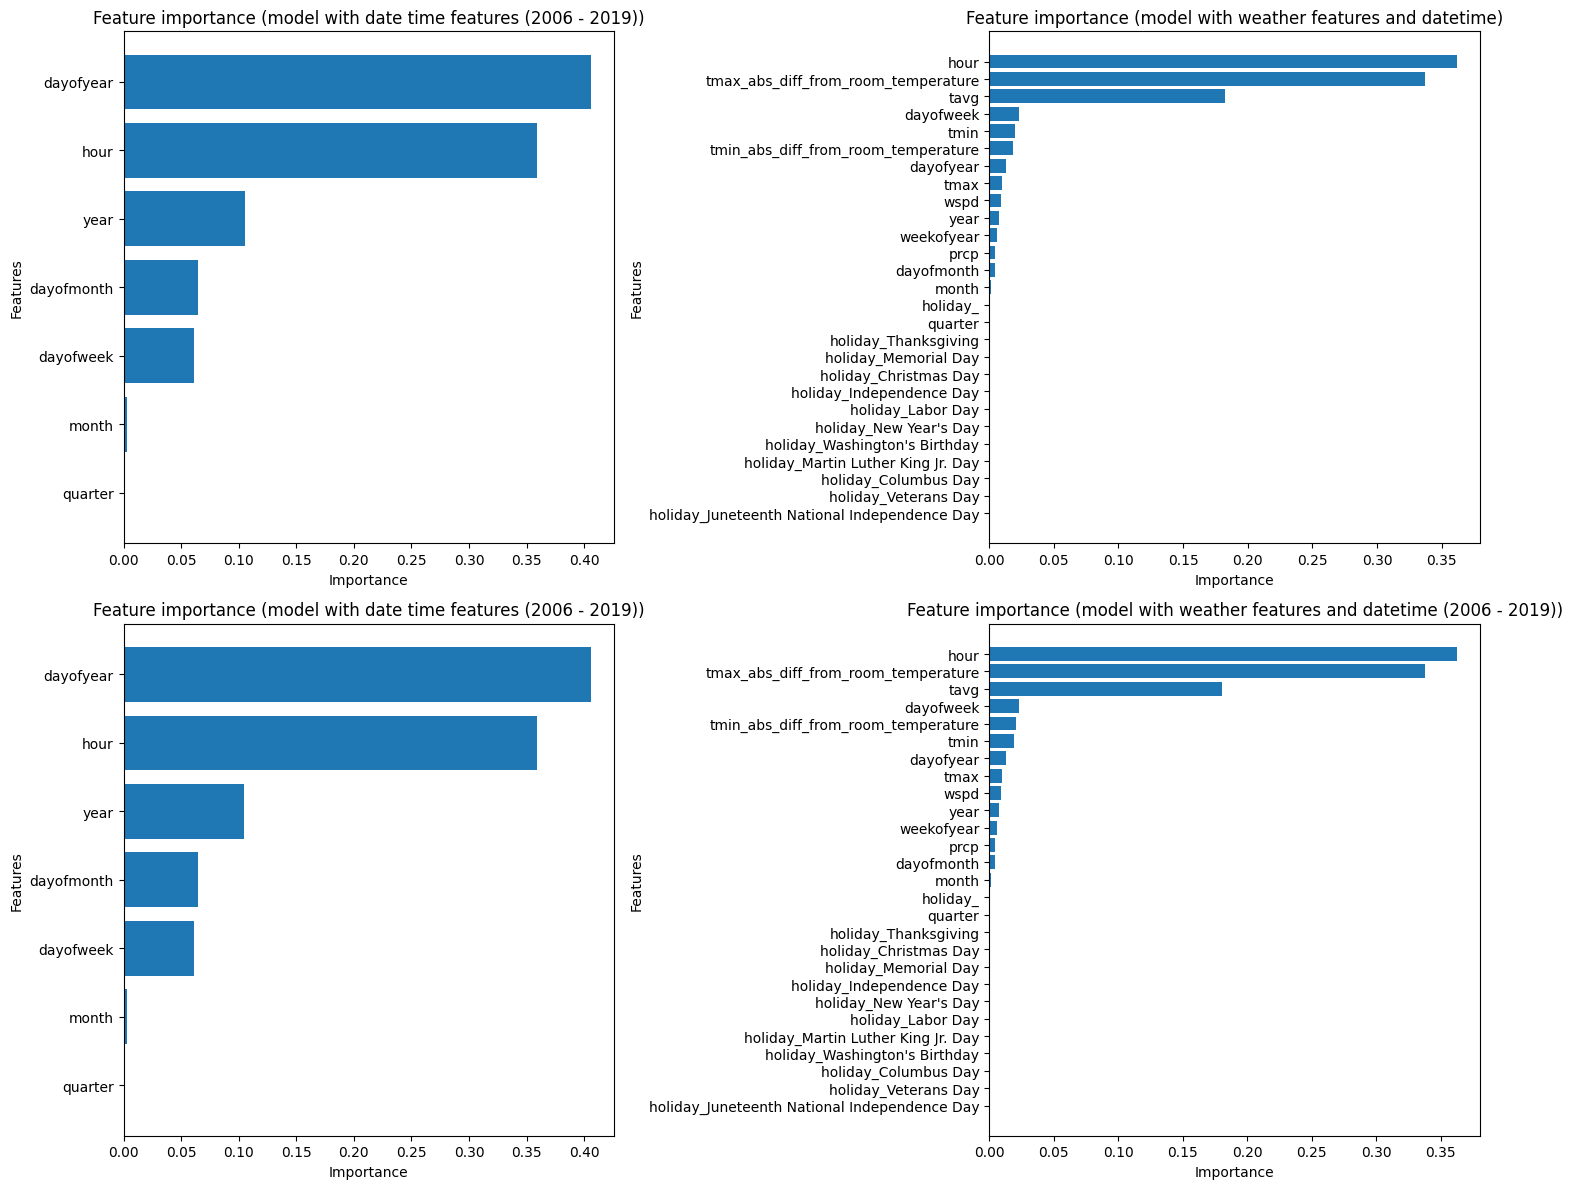

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure and set up 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Helper function to plot feature importance
def plot_rf_feature_importance(model, ax, title, feature_names):
    importances = model.feature_importances_
    indices = np.argsort(importances) # Sort feature importances in ascending order
    ax.barh(range(len(importances)), importances[indices], align="center") # Changed to barh for horizontal bars
    ax.set_yticks(range(len(importances))) # Set y-ticks
    ax.set_yticklabels(np.array(feature_names)[indices]) # Set y-tick labels
    ax.set_title(title)
    ax.set_ylabel('Features') # Changed x-label to y-label
    ax.set_xlabel('Importance') # Changed y-label to x-label

# Plot feature importance for each Random Forest model
# Pass the corresponding X_train.columns or feature names for each model
plot_rf_feature_importance(rfr_dt_reg, axes[0, 0], 'Feature importance (model with date time features (2006 - 2019))', X_train.columns)
plot_rf_feature_importance(rfr_all_reg, axes[0, 1], 'Feature importance (model with weather features and datetime)', X_train.columns)
plot_rf_feature_importance(rfr_dt2019_reg, axes[1, 0], 'Feature importance (model with date time features (2006 - 2019))', X_train.columns)
plot_rf_feature_importance(rfr_all2019_reg, axes[1, 1], 'Feature importance (model with weather features and datetime (2006 - 2019))', X_train.columns)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

## Retrain Model on case study

In [16]:
# Assuming Xgb_all2019_reg is already created and trained previously

# Splitting the data: training on 2020-2023, testing on 2024
split_date_train = datetime(2023, 7, 1)
train = case_study_data.loc[case_study_data['datetime'] < split_date_train].copy()  # Data from 2020 to end of 2023
test = case_study_data.loc[case_study_data['datetime'] >= split_date_train].copy()  # Data from 2024

# Dropping unnecessary columns for training and testing
train_drop_cols = ['date', 'datetime', 'energy_consumption_mw']  # Adjust 'date' column if necessary
X_train = train.drop(columns=train_drop_cols)
y_train = train['energy_consumption_mw']
X_test = test.drop(columns=train_drop_cols)
y_test = test['energy_consumption_mw']

# Retraining the existing Xgb_all2019_reg on the new data (2020-2023)
rfr_all2019_reg.fit(X_train, y_train)

# Predictions on 2024 data
predictions = rfr_all2019_reg.predict(X_test)

# Evaluation
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions) * 100  # Convert to percentage
r2 = rfr_all2019_reg.score(X_test, y_test) * 100  # Convert to percentage

# Print metrics
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape:.2f}%")  # Display MAPE as percentage with 2 decimal places
print(f"R^2: {r2:.2f}%")     # Display R^2 as percentage with 2 decimal places

RMSE: 1048.0194286627893
MAE: 834.4647670766861
MAPE: 5.75%
R^2: 82.24%


## Hyper parameter tunning

In [19]:
from sklearn.model_selection import GridSearchCV

split_date = datetime(2016, 1, 1)
train = data_till_2019.loc[data_till_2019['datetime'] <= split_date].copy()
test = data_till_2019.loc[data_till_2019['datetime'] > split_date].copy()
train_drop_cols = ['date', 'datetime', 'energy_consumption_mw']
X_train = train.drop(columns=train_drop_cols)
y_train = train['energy_consumption_mw']
X_test = test.drop(columns=train_drop_cols)
y_test = test['energy_consumption_mw']

# Define the parameter grid for tuning
param_grid = {
    'n_estimators': [50, 100],  # Number of trees in the forest
    'max_depth': [10, 20, None],  # Maximum depth of the tree
    'min_samples_split': [2, 5],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2]  # Minimum number of samples required to be at a leaf node
}

# Create the Random Forest Regressor
rfr = RandomForestRegressor()

# Perform Grid Search with 3-fold cross-validation
rfr_grid_search = GridSearchCV(estimator=rfr, param_grid=param_grid, cv=3, n_jobs=2, verbose=2, scoring='neg_mean_squared_error')

# Fit the grid search to the data
rfr_grid_search.fit(X_train, y_train)

# Best parameters from the grid search
rfr_best_params = rfr_grid_search.best_params_
print(f"Best parameters found: {rfr_best_params}")

# Predict using the best model
rfr_best_model = rfr_grid_search.best_estimator_
predictions = rfr_best_model.predict(X_test)

# Evaluation
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions) * 100  # Convert MAPE to percentage
r2 = rfr_best_model.score(X_test, y_test) * 100  # Convert R^2 to percentage

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}%")
print(f"R^2: {r2}%")


Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   5.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  11.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  12.4s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   5.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  11.8s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   5.9s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   5.8s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  11.5s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  11.6s
[CV] END max_depth=10, min_samples

[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   5.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   6.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  12.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   6.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   5.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  11.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  11.7s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   5.8s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  11.5s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   5

In [20]:
from sklearn.model_selection import GridSearchCV

split_date = datetime(2016, 1, 1)
train = data_till_2019.loc[data_till_2019['datetime'] <= split_date].copy()
test = data_till_2019.loc[data_till_2019['datetime'] > split_date].copy()
train_drop_cols = ['date', 'datetime', 'energy_consumption_mw']
X_train = train.drop(columns=train_drop_cols)
y_train = train['energy_consumption_mw']
X_test = test.drop(columns=train_drop_cols)
y_test = test['energy_consumption_mw']

# Define the parameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [10, 20, None],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 7],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 3]  # Minimum number of samples required to be at a leaf node
}

# Create the Random Forest Regressor
rfr = RandomForestRegressor()

# Perform Grid Search with 3-fold cross-validation
rfr_grid_search = GridSearchCV(estimator=rfr, param_grid=param_grid, cv=3, n_jobs=2, verbose=2, scoring='neg_mean_squared_error')

# Fit the grid search to the data
rfr_grid_search.fit(X_train, y_train)

# Best parameters from the grid search
rfr_best_params = rfr_grid_search.best_params_
print(f"Best parameters found: {rfr_best_params}")

# Predict using the best model
rfr_best_model = rfr_grid_search.best_estimator_
predictions = rfr_best_model.predict(X_test)

# Evaluation
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions) * 100  # Convert MAPE to percentage
r2 = rfr_best_model.score(X_test, y_test) * 100  # Convert R^2 to percentage

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}%")
print(f"R^2: {r2}%")

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=  10.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=  10.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=  10.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  21.2s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=  10.7s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=  10.7s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  21.2s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  21.1s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=  10.4s
[CV] END max_dept

[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  43.9s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  20.0s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  20.1s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  39.9s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=7, n_estimators=50; total time=   9.7s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=7, n_estimators=50; total time=   9.6s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=7, n_estimators=50; total time=   9.7s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=7, n_estimators=100; total time=  19.2s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=7, n_estimators=200; total time=  38.6s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=7, n_estimators=200; total time= 

[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  48.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  21.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  42.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=  10.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=  10.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=  10.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  21.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  21.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  42.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=7, n_estimato

In [22]:
# Save the best model to a file
joblib.dump(rfr_best_model, 'best_random_forest_model.pkl')
print("Model saved successfully!")

Model saved successfully!


In [23]:
# Load the saved model
rfr_loaded_model = joblib.load('best_random_forest_model.pkl')

# Use the loaded model for predictions
rfr_loaded_predictions = rfr_loaded_model.predict(X_test)

# Evaluate the loaded model
loaded_rmse = mean_squared_error(y_test, rfr_loaded_predictions, squared=False)
loaded_mae = mean_absolute_error(y_test, rfr_loaded_predictions)
loaded_mape = mean_absolute_percentage_error(y_test, rfr_loaded_predictions) * 100  # Convert to percentage
loaded_r2 = rfr_loaded_model.score(X_test, y_test) * 100  # Convert R^2 to percentage

print(f"Loaded Model RMSE: {loaded_rmse}")
print(f"Loaded Model MAE: {loaded_mae}")
print(f"Loaded Model MAPE: {loaded_mape}%")
print(f"Loaded Model R^2: {loaded_r2}%")


Loaded Model RMSE: 733.0537485009354
Loaded Model MAE: 566.5130441344542
Loaded Model MAPE: 4.89575763782084%
Loaded Model R^2: 91.01506983399489%


In [25]:
pip install --upgrade pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 2.8 MB/s eta 0:00:0000:0100:01m
  Attempting uninstall: pandas
    Found existing installation: pandas 2.1.4
    Uninstalling pandas-2.1.4:
      Successfully uninstalled pandas-2.1.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
seaborn 0.12.2 requires numpy!=1.24.0,>=1.17, but you have numpy 1.24.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


# Model Building 

In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from joblib import dump, load
from datetime import datetime

# Step 0: Set the global random seed
np.random.seed(22)

# Step 1: Data Preprocessing and Normalization using Min-Max Scaling
split_date = datetime(2016, 1, 1)
train = data_till_2019.loc[data_till_2019['datetime'] <= split_date].copy()
test = data_till_2019.loc[data_till_2019['datetime'] > split_date].copy()

train_drop_cols = ['date', 'datetime', 'energy_consumption_mw']
X_train = train.drop(columns=train_drop_cols)
y_train = train['energy_consumption_mw']
X_test = test.drop(columns=train_drop_cols)
y_test = test['energy_consumption_mw']

# Normalize the features using Min-Max Scaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 2: Train the Random Forest Regressor model
rfr_all2019_reg = RandomForestRegressor(random_state=22)
rfr_all2019_reg.fit(X_train_scaled, y_train)

# Predictions
predictions = rfr_all2019_reg.predict(X_test_scaled)

# Step 3: Model Evaluation
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)

print('Model Evaluation')
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"R^2: {rfr_all2019_reg.score(X_test_scaled, y_test) * 100:.2f}")

# Step 4: Save the trained model
dump(rfr_all2019_reg, 'saved models/RFR/rfr_all2019_reg_model.joblib')

# Step 5: Export actual vs. predictions to CSV for further analysis, with datetime as the index
test['Predicted'] = predictions
result_df = test[['datetime', 'energy_consumption_mw', 'Predicted']].set_index('datetime')
result_df.columns = ['Actual', 'rfr_2019_Predicted']  # Rename columns for clarity
result_df.to_csv('saved models/RFR/rfr_all2019_reg_model_predictions_vs_actuals.csv')

Model Evaluation
RMSE: 735.4620090007473
MAE: 569.1708152998043
MAPE: 4.92%
R^2: 90.96


In [12]:
# Case Study Example
split_date_train = datetime(2023, 7, 1)
train = case_study_data.loc[case_study_data['datetime'] < split_date_train].copy()
test = case_study_data.loc[case_study_data['datetime'] >= split_date_train].copy()

train_drop_cols = ['date', 'datetime', 'energy_consumption_mw']
X_train = train.drop(columns=train_drop_cols)
y_train = train['energy_consumption_mw']
X_test = test.drop(columns=train_drop_cols)
y_test = test['energy_consumption_mw']

# Normalize the new training and test data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 1: Load the previously saved model
loaded_model = load('saved models/RFR/rfr_all2019_reg_model.joblib')

# Step 2: Retrain the loaded model on 2020-2023 data
loaded_model.fit(X_train_scaled, y_train)

# Step 3: Make predictions on 2024 data
predictions = loaded_model.predict(X_test_scaled)

# Step 4: Evaluate the retrained model on the test set (2024 data)
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions) * 100  # Convert to percentage
r2 = loaded_model.score(X_test_scaled, y_test) * 100  # Convert to percentage

# Print evaluation metrics
print('Evaluation for case study July 2023 to July 2024')
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape:.2f}%")  # Display MAPE as percentage with 2 decimal places
print(f"R^2: {r2:.2f}%")     # Display R^2 as percentage with 2 decimal places

# Step 5: Save the retrained model
dump(loaded_model, 'saved models/RFR/rfr_all2020_2023_retrained_model.joblib')

# Step 6: Export actual vs. predictions for case study to CSV, with datetime as the index
test['Predicted'] = predictions
case_result_df = test[['datetime', 'energy_consumption_mw', 'Predicted']].set_index('datetime')
case_result_df.columns = ['Actual', 'rfr_2023_Predicted']  # Rename columns for clarity
case_result_df.to_csv('saved models/RFR/rfr_all2020_2023_retrained_model_case_study_predictions_vs_actuals.csv')

Evaluation for case study July 2023 to July 2024
RMSE: 1043.3580215347808
MAE: 834.8953987524488
MAPE: 5.75%
R^2: 82.40%


# HYPER PARAMETER TUNNING

## HP1

In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from joblib import dump, load
from datetime import datetime

# Step 0: Set the global random seed
np.random.seed(22)

# Step 1: Data Preprocessing and Normalization using Min-Max Scaling
split_date = datetime(2016, 1, 1)
train = data_till_2019.loc[data_till_2019['datetime'] <= split_date].copy()
test = data_till_2019.loc[data_till_2019['datetime'] > split_date].copy()

train_drop_cols = ['date', 'datetime', 'energy_consumption_mw']
X_train = train.drop(columns=train_drop_cols)
y_train = train['energy_consumption_mw']
X_test = test.drop(columns=train_drop_cols)
y_test = test['energy_consumption_mw']

# Normalize the features using Min-Max Scaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 2: Define the hyperparameter grid for Random Forest Regressor
param_grid = {
    'n_estimators': [50, 100],  # Number of trees in the forest
    'max_depth': [10, 20, None],  # Maximum depth of the tree
    'min_samples_split': [2, 5],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2]  # Minimum number of samples required to be at a leaf node
}

# Initialize the Random Forest Regressor
rfr = RandomForestRegressor(random_state=22)

# Step 3: Set up the GridSearchCV
rfr_grid_search = GridSearchCV(estimator=rfr,
                               param_grid=param_grid,
                               cv=3,  # Cross-validation folds
                               n_jobs=2,  # Use 2 cores
                               verbose=2,
                               scoring='neg_mean_squared_error')

# Fit the grid search to the training data
rfr_grid_search.fit(X_train_scaled, y_train)

# Step 4: Get the best model from GridSearchCV
rfr_best_model1 = rfr_grid_search.best_estimator_

# Step 5: Make predictions with the best model
predictions = rfr_best_model1.predict(X_test_scaled)

# Step 6: Model Evaluation
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)

print('Model Evaluation')
print(f"Best Parameters: {rfr_grid_search.best_params_}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"R^2: {rfr_best_model1.score(X_test_scaled, y_test) * 100:.2f}")

# Step 7: Save the best model from GridSearchCV
dump(rfr_best_model1, 'saved models/RFR/rfr_best_model_grid_search.joblib')

# Step 8: Export actual vs. predictions to CSV for further analysis, with datetime as the index
test['Predicted'] = predictions
result_df = test[['datetime', 'energy_consumption_mw', 'Predicted']].set_index('datetime')
result_df.columns = ['Actual', 'rfr_grid_search_predicted']  # Rename columns for clarity
result_df.to_csv('saved models/RFR/rfr_grid_search_predictions_vs_actuals.csv')


Fitting 3 folds for each of 24 candidates, totalling 72 fits


/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   5.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  11.6s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  11.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   5.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  11.6s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   5.8s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   5.8s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  11.6s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  11.7s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   

/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


[CV] END max_depth=None, min_samples_leaf=3, min_samples_split=7, n_estimators=100; total time=  19.4s
[CV] END max_depth=None, min_samples_leaf=3, min_samples_split=7, n_estimators=200; total time=  38.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   5.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   5.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  11.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   5.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   5.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  11.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  11.7s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time

/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  22.1s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=  10.1s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=  10.1s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=  10.1s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  20.2s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=  10.0s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=  10.1s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  20.1s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  20.2s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   9

/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  22.2s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  20.2s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  20.3s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=  10.1s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  20.2s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=  10.0s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   9.9s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  19.8s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  19.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=

/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  12.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  24.2s


/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=  10.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=  10.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=  10.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  21.6s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=  10.6s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=  10.6s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  21.3s


/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Model Evaluation
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
RMSE: 735.4620090007473
MAE: 569.1708152998043
MAPE: 4.92%
R^2: 90.96


In [16]:
# Case Study Example (2020-2023 training, 2024 testing)
split_date_train = datetime(2023, 7, 1)
train = case_study_data.loc[case_study_data['datetime'] < split_date_train].copy()
test = case_study_data.loc[case_study_data['datetime'] >= split_date_train].copy()

train_drop_cols = ['date', 'datetime', 'energy_consumption_mw']
X_train = train.drop(columns=train_drop_cols)
y_train = train['energy_consumption_mw']
X_test = test.drop(columns=train_drop_cols)
y_test = test['energy_consumption_mw']

# Normalize the new training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 9: Load the best model from the previous training
loaded_model = load('saved models/RFR/rfr_best_model_grid_search.joblib')

# Step 10: Retrain the loaded model on 2020-2023 data
loaded_model.fit(X_train_scaled, y_train)

# Step 11: Make predictions on 2024 data
predictions = loaded_model.predict(X_test_scaled)

# Step 12: Evaluate the retrained model on the test set (2024 data)
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions) * 100  # Convert to percentage
r2 = loaded_model.score(X_test_scaled, y_test) * 100  # Convert to percentage

# Print evaluation metrics
print('Evaluation for case study July 2023 to July 2024')
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape:.2f}%")  # Display MAPE as percentage with 2 decimal places
print(f"R^2: {r2:.2f}%")     # Display R^2 as percentage with 2 decimal places

# Step 13: Save the retrained model
dump(loaded_model, 'saved models/RFR/rfr_2020_2023_retrained_grid_search_model.joblib')

# Step 14: Export actual vs. predictions for case study to CSV, with datetime as the index
test['Predicted'] = predictions
case_result_df = test[['datetime', 'energy_consumption_mw', 'Predicted']].set_index('datetime')
case_result_df.columns = ['Actual', 'rfr_grid_search_2023_predicted']  # Rename columns for clarity
case_result_df.to_csv('saved models/RFR/rfr_grid_search_2023_predictions_vs_actuals.csv')


Evaluation for case study July 2023 to July 2024
RMSE: 1043.3580215347808
MAE: 834.8953987524488
MAPE: 5.75%
R^2: 82.40%
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  21.2s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=  10.3s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  21.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  24.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  21.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  21.7s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=  10.6s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  21.4s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_

## HP2

In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from joblib import dump, load
from datetime import datetime

# Step 0: Set the global random seed
np.random.seed(22)

# Step 1: Data Preprocessing and Normalization using Min-Max Scaling
split_date = datetime(2016, 1, 1)
train = data_till_2019.loc[data_till_2019['datetime'] <= split_date].copy()
test = data_till_2019.loc[data_till_2019['datetime'] > split_date].copy()

train_drop_cols = ['date', 'datetime', 'energy_consumption_mw']
X_train = train.drop(columns=train_drop_cols)
y_train = train['energy_consumption_mw']
X_test = test.drop(columns=train_drop_cols)
y_test = test['energy_consumption_mw']

# Normalize the features using Min-Max Scaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 2: Define the hyperparameter grid for Random Forest Regressor
# Define the parameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [10, 20, None],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 7],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 3]  # Minimum number of samples required to be at a leaf node
}

# Initialize the Random Forest Regressor
rfr = RandomForestRegressor(random_state=22)

# Step 3: Set up the GridSearchCV
rfr_grid_search = GridSearchCV(estimator=rfr,
                               param_grid=param_grid,
                               cv=3,  # Cross-validation folds
                               n_jobs=2,  # Use 2 cores
                               verbose=2,
                               scoring='neg_mean_squared_error')

# Fit the grid search to the training data
rfr_grid_search.fit(X_train_scaled, y_train)

# Step 4: Get the best model from GridSearchCV
rfr_best_model2 = rfr_grid_search.best_estimator_

# Step 5: Make predictions with the best model
predictions = rfr_best_model2.predict(X_test_scaled)

# Step 6: Model Evaluation
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)

print('Model Evaluation')
print(f"Best Parameters: {rfr_grid_search.best_params_}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"R^2: {rfr_best_model2.score(X_test_scaled, y_test) * 100:.2f}")

# Step 7: Save the best model from GridSearchCV
dump(rfr_best_model2, 'saved models/RFR/rfr_best_model_grid_search2.joblib')

# Step 8: Export actual vs. predictions to CSV for further analysis, with datetime as the index
test['Predicted'] = predictions
result_df = test[['datetime', 'energy_consumption_mw', 'Predicted']].set_index('datetime')
result_df.columns = ['Actual', 'rfr_grid_search_predicted2']  # Rename columns for clarity
result_df.to_csv('saved models/RFR/rfr_grid_search_predictions_vs_actuals2.csv')


Fitting 3 folds for each of 81 candidates, totalling 243 fits


/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import 

[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   5.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   5.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  11.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  23.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  23.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  11.6s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  23.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  23.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=7, n_estimators=100; total time=  11.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=7, n_estimators=100; total time=

/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   5.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  11.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  11.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  23.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   5.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   5.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   5.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  11.6s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  11.6s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  

/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  44.1s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  44.2s


/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  22.1s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  22.1s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  44.1s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=  10.1s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=  10.1s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=  10.2s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  20.2s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  40.6s


/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  20.3s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  20.2s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  40.7s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=7, n_estimators=50; total time=   9.7s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=7, n_estimators=50; total time=   9.8s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=7, n_estimators=50; total time=   9.8s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=7, n_estimators=100; total time=  19.6s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=7, n_estimators=200; total time=  38.9s


/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  40.6s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=7, n_estimators=100; total time=  19.6s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=7, n_estimators=100; total time=  19.5s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=7, n_estimators=200; total time=  39.1s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=  10.0s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=  10.1s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=  10.1s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  20.1s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  40.4s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time= 

/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=7, n_estimators=200; total time=  39.1s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  20.1s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  20.1s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  40.4s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   9.8s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   9.9s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   9.9s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  19.8s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  39.4s


/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  19.8s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  19.8s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  39.5s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=7, n_estimators=50; total time=   9.6s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=7, n_estimators=50; total time=   9.6s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=7, n_estimators=50; total time=   9.7s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=7, n_estimators=100; total time=  19.3s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=7, n_estimators=200; total time=  38.1s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=7, n_estimators=200; total time=  38.4s


/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


[CV] END max_depth=20, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=  19.0s
[CV] END max_depth=20, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=  19.0s
[CV] END max_depth=20, min_samples_leaf=3, min_samples_split=2, n_estimators=200; total time=  37.9s
[CV] END max_depth=20, min_samples_leaf=3, min_samples_split=5, n_estimators=50; total time=   9.4s
[CV] END max_depth=20, min_samples_leaf=3, min_samples_split=5, n_estimators=50; total time=   9.5s
[CV] END max_depth=20, min_samples_leaf=3, min_samples_split=5, n_estimators=50; total time=   9.4s


/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


[CV] END max_depth=20, min_samples_leaf=3, min_samples_split=5, n_estimators=100; total time=  19.0s
[CV] END max_depth=20, min_samples_leaf=3, min_samples_split=5, n_estimators=200; total time=  38.0s
[CV] END max_depth=20, min_samples_leaf=3, min_samples_split=5, n_estimators=200; total time=  38.1s


/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


[CV] END max_depth=20, min_samples_leaf=3, min_samples_split=7, n_estimators=100; total time=  18.8s
[CV] END max_depth=20, min_samples_leaf=3, min_samples_split=7, n_estimators=100; total time=  18.8s
[CV] END max_depth=20, min_samples_leaf=3, min_samples_split=7, n_estimators=200; total time=  37.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  12.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  12.1s


/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  39.8s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=7, n_estimators=100; total time=  19.3s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=7, n_estimators=100; total time=  19.1s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=7, n_estimators=200; total time=  38.2s
[CV] END max_depth=20, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   9.5s
[CV] END max_depth=20, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   9.7s
[CV] END max_depth=20, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   9.5s
[CV] END max_depth=20, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=  19.0s
[CV] END max_depth=20, min_samples_leaf=3, min_samples_split=2, n_estimators=200; total time=  38.0s
[CV] END max_depth=20, min_samples_leaf=3, min_samples_split=2, n_estimators=200; total time= 

/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  24.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  24.2s


/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  48.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  48.3s


/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  48.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=  10.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=  10.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=  10.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  21.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  21.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  42.3s


/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  21.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  42.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  42.6s


/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=7, n_estimators=50; total time=  10.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=7, n_estimators=50; total time=  10.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=7, n_estimators=50; total time=  10.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=7, n_estimators=100; total time=  20.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=7, n_estimators=200; total time=  40.7s


/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=7, n_estimators=100; total time=  20.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=7, n_estimators=100; total time=  20.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=7, n_estimators=200; total time=  40.7s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=  10.6s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=  10.6s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=  10.6s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  21.1s


/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=7, n_estimators=200; total time=  40.6s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  21.1s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  21.1s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  42.1s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=  10.3s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=  10.3s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=  10.3s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  20.6s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  41.3s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimato

/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=7, n_estimators=100; total time=  19.9s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=7, n_estimators=100; total time=  19.8s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=7, n_estimators=200; total time=  39.7s
[CV] END max_depth=None, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   9.9s
[CV] END max_depth=None, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   9.8s
[CV] END max_depth=None, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   9.8s
[CV] END max_depth=None, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=  19.6s


/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


[CV] END max_depth=None, min_samples_leaf=3, min_samples_split=2, n_estimators=200; total time=  39.5s
[CV] END max_depth=None, min_samples_leaf=3, min_samples_split=2, n_estimators=200; total time=  39.3s
[CV] END max_depth=None, min_samples_leaf=3, min_samples_split=5, n_estimators=100; total time=  19.8s
[CV] END max_depth=None, min_samples_leaf=3, min_samples_split=5, n_estimators=100; total time=  19.6s
[CV] END max_depth=None, min_samples_leaf=3, min_samples_split=5, n_estimators=200; total time=  39.3s


/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  42.9s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  42.7s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  20.9s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  20.9s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  41.8s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=7, n_estimators=50; total time=  10.0s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=7, n_estimators=50; total time=  10.0s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=7, n_estimators=50; total time=  10.1s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=7, n_estimators=100; total time=  20.0s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=7, n_estimato

/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


[CV] END max_depth=None, min_samples_leaf=3, min_samples_split=7, n_estimators=50; total time=   9.8s
[CV] END max_depth=None, min_samples_leaf=3, min_samples_split=7, n_estimators=50; total time=   9.7s
[CV] END max_depth=None, min_samples_leaf=3, min_samples_split=7, n_estimators=50; total time=   9.7s
[CV] END max_depth=None, min_samples_leaf=3, min_samples_split=7, n_estimators=100; total time=  19.5s
[CV] END max_depth=None, min_samples_leaf=3, min_samples_split=7, n_estimators=200; total time=  38.9s
[CV] END max_depth=None, min_samples_leaf=3, min_samples_split=7, n_estimators=200; total time=  38.2s
Model Evaluation
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
RMSE: 733.055987434644
MAE: 567.2424075079681
MAPE: 4.90%
R^2: 91.02


In [14]:
# Case Study Example (2020-2023 training, 2024 testing)
split_date_train = datetime(2023, 7, 1)
train = case_study_data.loc[case_study_data['datetime'] < split_date_train].copy()
test = case_study_data.loc[case_study_data['datetime'] >= split_date_train].copy()

train_drop_cols = ['date', 'datetime', 'energy_consumption_mw']
X_train = train.drop(columns=train_drop_cols)
y_train = train['energy_consumption_mw']
X_test = test.drop(columns=train_drop_cols)
y_test = test['energy_consumption_mw']

# Normalize the new training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 9: Load the best model from the previous training
loaded_model = load('saved models/RFR/rfr_best_model_grid_search2.joblib')

# Step 10: Retrain the loaded model on 2020-2023 data
loaded_model.fit(X_train_scaled, y_train)

# Step 11: Make predictions on 2024 data
predictions = loaded_model.predict(X_test_scaled)

# Step 12: Evaluate the retrained model on the test set (2024 data)
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions) * 100  # Convert to percentage
r2 = loaded_model.score(X_test_scaled, y_test) * 100  # Convert to percentage

# Print evaluation metrics
print('Evaluation for case study July 2023 to July 2024')
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape:.2f}%")  # Display MAPE as percentage with 2 decimal places
print(f"R^2: {r2:.2f}%")     # Display R^2 as percentage with 2 decimal places

# Step 13: Save the retrained model
dump(loaded_model, 'saved models/RFR/rfr_2020_2023_retrained_grid_search_model.joblib')

# Step 14: Export actual vs. predictions for case study to CSV, with datetime as the index
test['Predicted'] = predictions
case_result_df = test[['datetime', 'energy_consumption_mw', 'Predicted']].set_index('datetime')
case_result_df.columns = ['Actual', 'rfr_grid_search_2023_predicted2']  # Rename columns for clarity
case_result_df.to_csv('saved models/RFR/rfr_grid_search_2023_predictions_vs_actuals2.csv')


Evaluation for case study July 2023 to July 2024
RMSE: 1043.548554746367
MAE: 833.7098325708437
MAPE: 5.74%
R^2: 82.39%
